In [61]:
import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet

import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
plotly.plotly.sign_in('spersad', 'oNkuP1yzbpN734Ag8M9P')
import plotly.graph_objs as go

from IPython.core.display import display, HTML


In [62]:
data = pd.read_csv('data_CNA.xls.txt',sep='\t')
labels= pd.read_csv('OLD_DATA/data_clinical_sample_clean.tsv',sep='\t')

data.set_index('Hugo_Symbol', inplace=True)
labels.set_index('SAMPLE_ID', inplace=True)

data.drop(['Entrez_Gene_Id'], axis=1,inplace=True)
labels.drop(['Unnamed: 0'], axis=1,inplace=True)
data = data.transpose() # Convert data to matrix, rows are tumour samples

labels = labels['ONCOTREE_CODE']
result = pd.concat([data, labels], axis=1)
result.head()

labels=result['ONCOTREE_CODE']

X = data.as_matrix() 
Y = labels

print(X.shape)

(103, 23109)


Dataset CNA Regression , train_samples=70, n_features=23109, n_classes=4
Using l1 regression
[model=One versus Rest, solver=liblinear] Number of epochs: 1
[model=One versus Rest, solver=liblinear] Number of epochs: 3
Test accuracy for model ovr: 0.5455
Train accuracy for model ovr: 1.0000
% non-zero coefficients for model ovr, per class:
 [ 0.87411831  0.9433554   0.83949976  0.91306417]
Run time (3 epochs) for model ovr:0.12
Example run in 0.303 s


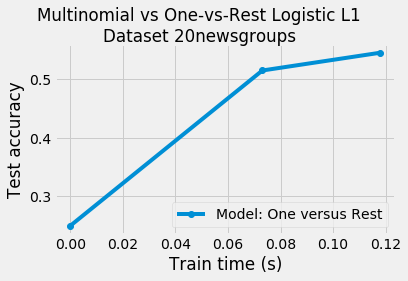

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import time

num_training =  70
X_train, y_train = X[:num_training], Y[:num_training]
#X_val, y_val = #TODO : add a validation set for terminating algorithm
X_test, y_test = X[num_training:], Y[num_training:]

t0 = time.clock()


# Turn down for faster run time
n_samples = 10000

penalty = 'l1'

train_samples, n_features = X_train.shape
n_classes = np.unique(Y).shape[0]

print('Dataset CNA Regression , train_samples=%i, n_features=%i, n_classes=%i'
      % (train_samples, n_features, n_classes))

models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 3, 7, 13]},
          'multinomial': {'name': 'Multinomial', 'iters': [1, 3, 7, 13, 19]}}

# Solver which handles multiclass and l1 penalty
solver = 'newton-cg'

if penalty == 'l1':
    print('Using l1 regression')
    models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 3]}}
    solver = 'liblinear'
    
for model in models:
    # Add initial chance-level values for plotting purpose
    accuracies = [1 / n_classes]
    train_accuracies = [1/n_classes]
    times = [0]
    densities = [1]

    model_params = models[model]

    # Small number of epochs for fast runtime
    for this_max_iter in model_params['iters']:
        print('[model=%s, solver=%s] Number of epochs: %s' %
              (model_params['name'], solver, this_max_iter))
        lr = LogisticRegression(solver=solver,
                                multi_class=model,
                                C=1,
                                penalty=penalty,
                                fit_intercept=True,
                                max_iter=this_max_iter,
                                random_state=42,
                                )
        t1 = time.clock()
        lr.fit(X_train, y_train)
        train_time = time.clock() - t1

        y_pred = lr.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        accuracies.append(accuracy)
        
        density = np.mean(lr.coef_ != 0, axis=1) * 100
        densities.append(density)
        
        tr_accuracy = np.sum(lr.predict(X_train) == y_train) / y_train.shape[0]
        train_accuracies.append(tr_accuracy)
        
        times.append(train_time)
    models[model]['times'] = times
    models[model]['densities'] = densities
    models[model]['test_accuracies'] = accuracies
    models[model]['weights'] = lr.coef_
    models[model]['train_accuracies'] = train_accuracies
    models[model]['weights'] = lr.coef_
    
    print('Test accuracy for model %s: %.4f' % (model, accuracies[-1]))
    print('Train accuracy for model %s: %.4f' % (model, train_accuracies[-1]))
    print('%% non-zero coefficients for model %s, '
          'per class:\n %s' % (model, densities[-1]))
    print('Run time (%i epochs) for model %s:'
          '%.2f' % (model_params['iters'][-1], model, times[-1]))

fig = plt.figure()
ax = fig.add_subplot(111)

for model in models:
    name = models[model]['name']
    times = models[model]['times']
    accuracies = models[model]['test_accuracies']
    ax.plot(times, accuracies, marker='o',
            label='Model: %s' % name)
    ax.set_xlabel('Train time (s)')
    ax.set_ylabel('Test accuracy')
ax.legend()
fig.suptitle('Multinomial vs One-vs-Rest Logistic L1\n'
             'Dataset %s' % '20newsgroups')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = time.clock() - t0
print('Example run in %.3f s' % run_time)
plt.show()

In [64]:
preds

array([1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0])

In [65]:
y_pred

array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 2, 2, 0, 1], dtype=int64)

In [66]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_test, y_pred)
print(c)
trace = go.Heatmap(z=c.T,
                   x=['BREAST','IDC', 'MDLC', 'ILC'],
                   y=['BREAST','IDC', 'MDLC', 'ILC'])
data=[trace]
iplot(data, filename='basic-heatmap')

[[ 1  5  0  0]
 [ 3 16  2  1]
 [ 1  1  1  0]
 [ 0  2  0  0]]


In [67]:
y_train.value_counts(1)

1    0.642857
0    0.142857
2    0.114286
3    0.100000
Name: ONCOTREE_CODE, dtype: float64

In [68]:
Y.value_counts(1)

1    0.650485
0    0.155340
2    0.106796
3    0.087379
Name: ONCOTREE_CODE, dtype: float64

In [69]:
lr

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=3, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
lr.predict(X_train)

array([1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 3, 3, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 2, 2, 0, 2, 1, 3,
       2, 3, 1, 1, 0, 1, 1, 1, 1, 2, 3, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1,
       1], dtype=int64)

In [71]:
c = confusion_matrix(y_train, lr.predict(X_train))
print(c)
trace = go.Heatmap(z=c.T,
                   x=['BREAST','IDC', 'MDLC', 'ILC'],
                   y=['BREAST','IDC', 'MDLC', 'ILC'])
data=[trace]
iplot(data, filename='basic-heatmap')

[[10  0  0  0]
 [ 0 45  0  0]
 [ 0  0  8  0]
 [ 0  0  0  7]]


In [72]:
models

{'ovr': {'densities': [1,
   array([ 1.41936042,  1.55350729,  1.03855641,  1.25924964]),
   array([ 0.87411831,  0.9433554 ,  0.83949976,  0.91306417])],
  'iters': [1, 3],
  'name': 'One versus Rest',
  'test_accuracies': [0.25, 0.51515151515151514, 0.54545454545454541],
  'times': [0, 0.07308231637534846, 0.11788317364789691],
  'train_accuracies': [0.25, 1.0, 1.0],
  'weights': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]])}}

In [74]:
weights = models['ovr']['weights']

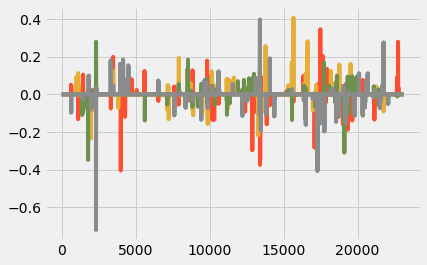

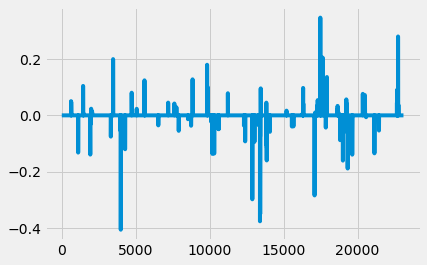

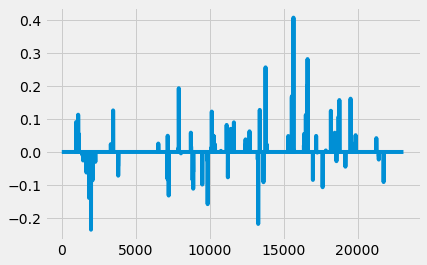

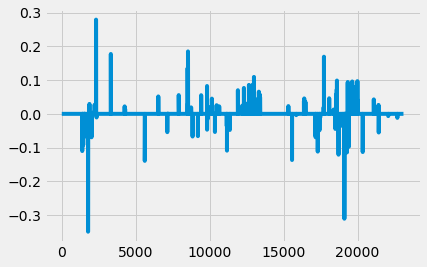

In [77]:
for weight in weights:
    plt.plot(weight)
    plt.show()

Dataset CNA Regression , train_samples=24, n_features=23109, n_classes=4
Using l1 regression
[model=One versus Rest, solver=liblinear] Number of epochs: 1
[model=One versus Rest, solver=liblinear] Number of epochs: 3
Test accuracy for model ovr: 0.2911
Train accuracy for model ovr: 1.0000
% non-zero coefficients for model ovr, per class:
 [ 0.36349474  0.2120386   0.41974988]
Run time (3 epochs) for model ovr:0.05
Example run in 0.259 s


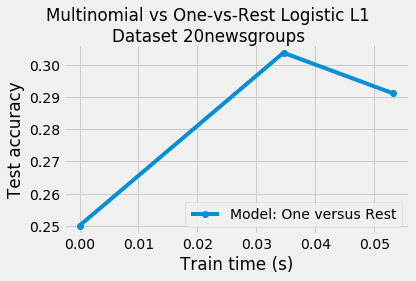

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import time

num_training =  24
X_train, y_train = X[Y!=1][:num_training], Y[Y!=1][:num_training]
#X_val, y_val = #TODO : add a validation set for terminating algorithm
X_test, y_test = X[num_training:], Y[num_training:]

t0 = time.clock()


# Turn down for faster run time
n_samples = 10000

penalty = 'l1'

train_samples, n_features = X_train.shape
n_classes = np.unique(Y).shape[0]

print('Dataset CNA Regression , train_samples=%i, n_features=%i, n_classes=%i'
      % (train_samples, n_features, n_classes))

models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 3, 7, 13]},
          'multinomial': {'name': 'Multinomial', 'iters': [1, 3, 7, 13, 19]}}

# Solver which handles multiclass and l1 penalty
solver = 'newton-cg'

if penalty == 'l1':
    print('Using l1 regression')
    models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 3]}}
    solver = 'liblinear'
    
for model in models:
    # Add initial chance-level values for plotting purpose
    accuracies = [1 / n_classes]
    train_accuracies = [1/n_classes]
    times = [0]
    densities = [1]

    model_params = models[model]

    # Small number of epochs for fast runtime
    for this_max_iter in model_params['iters']:
        print('[model=%s, solver=%s] Number of epochs: %s' %
              (model_params['name'], solver, this_max_iter))
        lr = LogisticRegression(solver=solver,
                                multi_class=model,
                                C=1,
                                penalty=penalty,
                                fit_intercept=True,
                                max_iter=this_max_iter,
                                random_state=42,
                                )
        t1 = time.clock()
        lr.fit(X_train, y_train)
        train_time = time.clock() - t1

        y_pred = lr.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        accuracies.append(accuracy)
        
        density = np.mean(lr.coef_ != 0, axis=1) * 100
        densities.append(density)
        
        tr_accuracy = np.sum(lr.predict(X_train) == y_train) / y_train.shape[0]
        train_accuracies.append(tr_accuracy)
        
        times.append(train_time)
    models[model]['times'] = times
    models[model]['densities'] = densities
    models[model]['test_accuracies'] = accuracies
    models[model]['weights'] = lr.coef_
    models[model]['train_accuracies'] = train_accuracies
    models[model]['weights'] = lr.coef_
    
    print('Test accuracy for model %s: %.4f' % (model, accuracies[-1]))
    print('Train accuracy for model %s: %.4f' % (model, train_accuracies[-1]))
    print('%% non-zero coefficients for model %s, '
          'per class:\n %s' % (model, densities[-1]))
    print('Run time (%i epochs) for model %s:'
          '%.2f' % (model_params['iters'][-1], model, times[-1]))

fig = plt.figure()
ax = fig.add_subplot(111)

for model in models:
    name = models[model]['name']
    times = models[model]['times']
    accuracies = models[model]['test_accuracies']
    ax.plot(times, accuracies, marker='o',
            label='Model: %s' % name)
    ax.set_xlabel('Train time (s)')
    ax.set_ylabel('Test accuracy')
ax.legend()
fig.suptitle('Multinomial vs One-vs-Rest Logistic L1\n'
             'Dataset %s' % '20newsgroups')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = time.clock() - t0
print('Example run in %.3f s' % run_time)
plt.show()

In [ ]:
X_train